In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.signal
from mpl_toolkits import mplot3d


data = np.loadtxt("elNino.txt", usecols=range(1,13), dtype='float')
print(tempdiff := np.ndarray.flatten(data))

[-1.   -1.2  -0.83 ... -0.99 -0.76 -0.86]


Plot the time series:

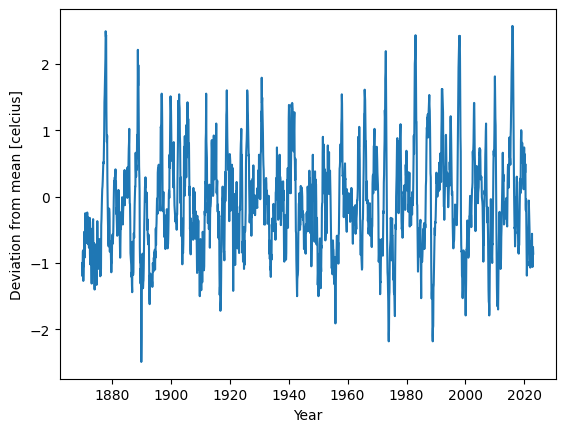

1836


In [9]:
flat_data = tempdiff
t = pd.date_range(start='1870-01-01',
                  end='2022-12-31',
                  periods=len(flat_data))
plt.plot(t, flat_data)
plt.xlabel("Year")
plt.ylabel("Deviation from mean [celcius]")
plt.show()
print(len(flat_data))

Plot the return map using different lags:

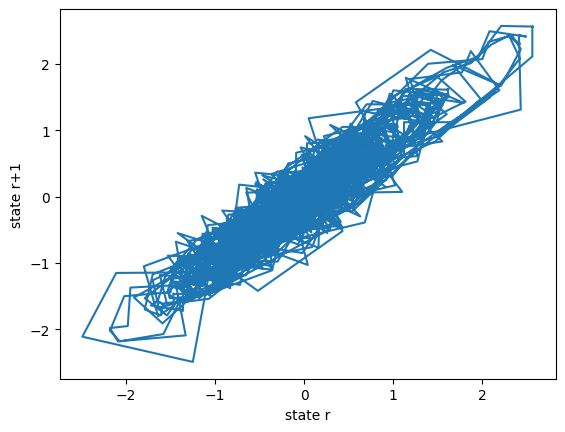

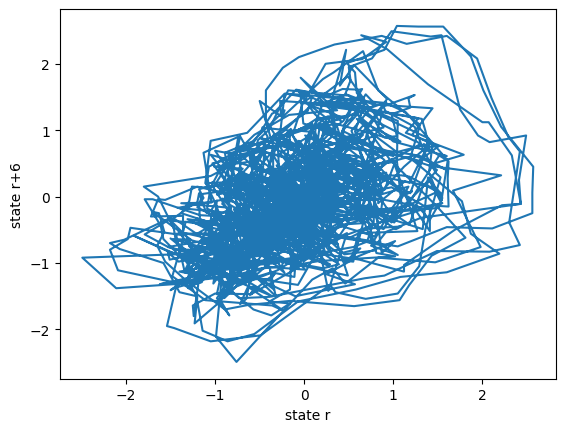

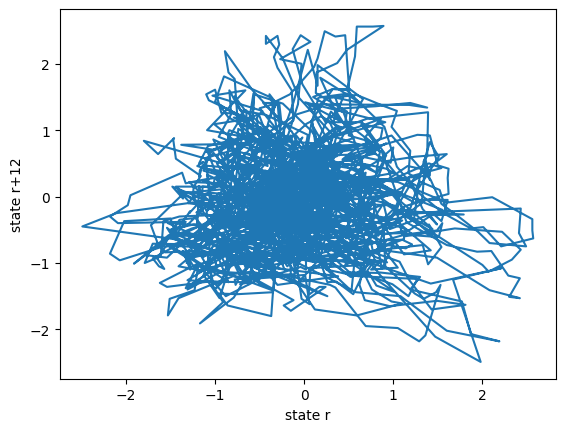

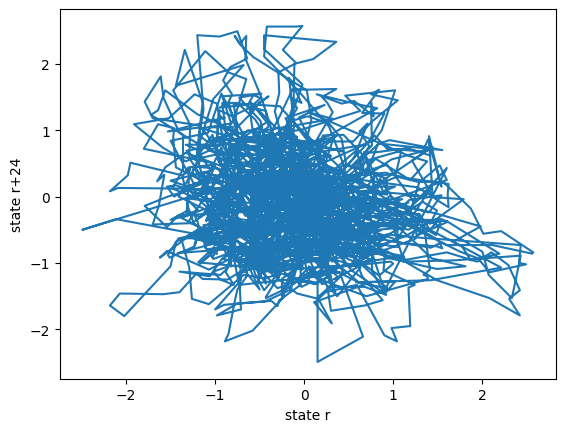

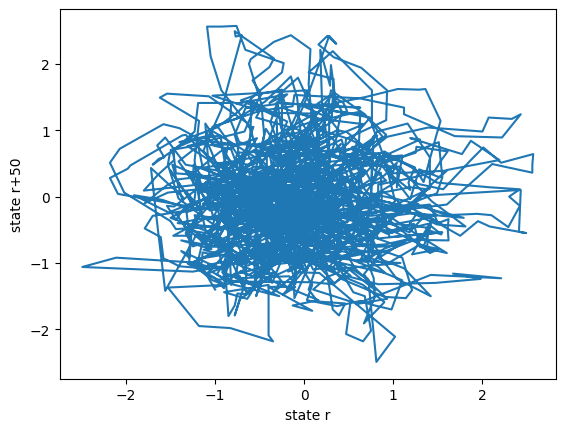

In [10]:
taus = [1, 6, 12, 24, 50]
for tau in taus:
    plt.plot(tempdiff[:-(tau)], tempdiff[tau:])
    plt.xlabel("state r")
    plt.ylabel("state r+" + str(tau))
    plt.show()


Plot the distribution of data values, calculate my, sigma, S, and K:

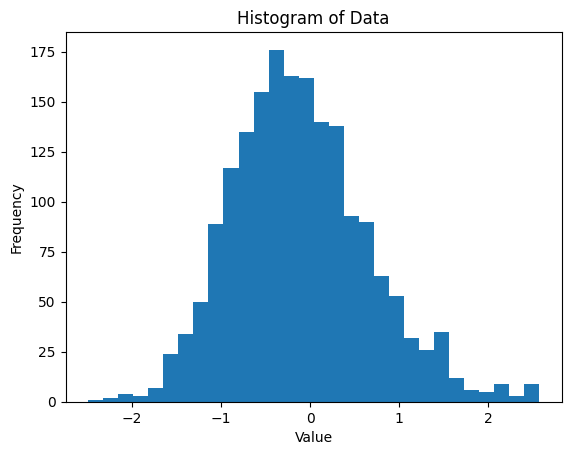

-0.17
-0.10785403050108931
0.4713713415690935
0.4180523627779258


In [11]:


plt.hist(flat_data, 30)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

S = np.std(flat_data)
median = np.median(flat_data)
mean = np.mean(flat_data)
variance = np.var(flat_data)
skewness = scipy.stats.skew(flat_data)
kurtosis = scipy.stats.kurtosis(flat_data)
CoV = S/abs(mean)
print(median)
print(mean)
print(skewness)
print(kurtosis)

STILL NOT DONE: CALCULATE THE ACF:

Calculate the PSD:

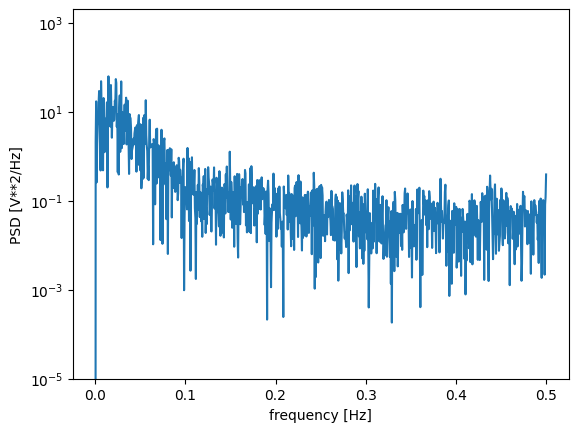

0.014


In [26]:
seconds_in_month = 2592000
(f, S) = scipy.signal.periodogram(flat_data, 1, scaling='density')
plt.semilogy(f, S)
plt.xlim
plt.ylim(10**-5, 2*10**3)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()
print(1/(ISI:=1000/14))

Reconstruct the attractor by using peaks from the PSD:

1812
1812
1812


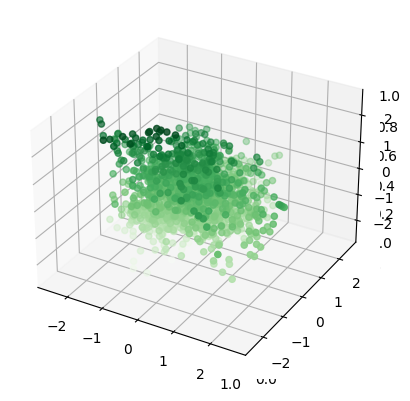

In [28]:
tau = 12

ax = plt.axes(projection='3d')

zline = tempdiff[:-(2*tau)]
xline = tempdiff[tau:-(tau)]
yline = tempdiff[2*tau:]

print(len(xline))
print(len(yline))

print(len(zline))

ax = plt.axes(projection='3d')
ax.scatter3D(xline, yline, zline, c=zline, cmap='Greens')